In [1]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Load Dataset
dataset = pd.read_csv(r"C:\Users\devgo\Downloads\WheatData.csv")
dataset.head()

,A,P,C,LK,WK,A_Coef,LKG,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


In [3]:
#Key Attributes
dataset.describe()

,A,P,C,LK,WK,A_Coef,LKG,target
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,1.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,0.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,0.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,1.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,2.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,2.000000


In [4]:
#Create x and y variables
x = dataset.drop('target', axis=1).to_numpy()
y = dataset['target'].to_numpy()

#Create Train and Test Dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20,stratify=y,random_state=100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.transform(x_test)

#Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
#Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_rdf = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier(random_state=100))])
pipeline.insert(0,pipe_rdf)

pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('clf', DecisionTreeClassifier(random_state=100))])
pipeline.insert(1,pipe_dt)

# Set grid search params 

modelpara =[]

param_gridrdf = {
            'clf__criterion':['gini','entropy'],
            'clf__n_estimators': [100,150,200],
            'clf__bootstrap': [True, False]}
modelpara.insert(0,param_gridrdf)

max_depth = range(1,100)
param_griddt = {'clf__criterion':['gini','entropy'],
                'clf__max_depth':max_depth}
modelpara.insert(1,param_griddt)

In [6]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train, 
                                                            y=y_train,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()

Decision Tree - Learning Curve


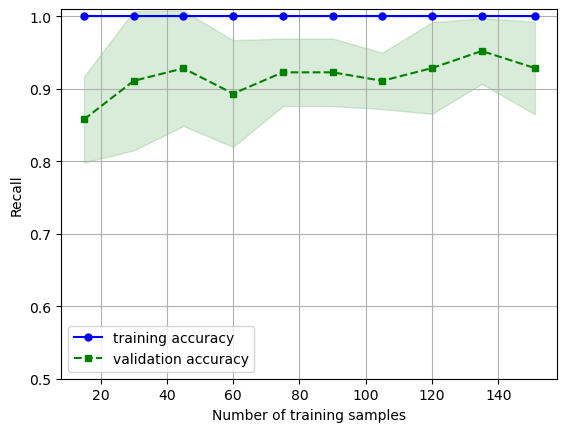


Random Forest - Learning Curve


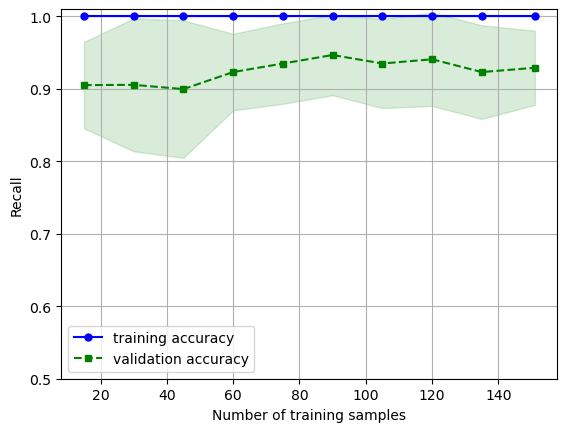

In [7]:
#Plot Learning Curve
print('Decision Tree - Learning Curve')
plot_learning_curves(pipe_dt)
print('\nRandom Forest - Learning Curve')
plot_learning_curves(pipe_rdf)

Model Evaluation - Recall
Decision Tree 0.94 +/- 0.05
Random Forest 0.93 +/- 0.05




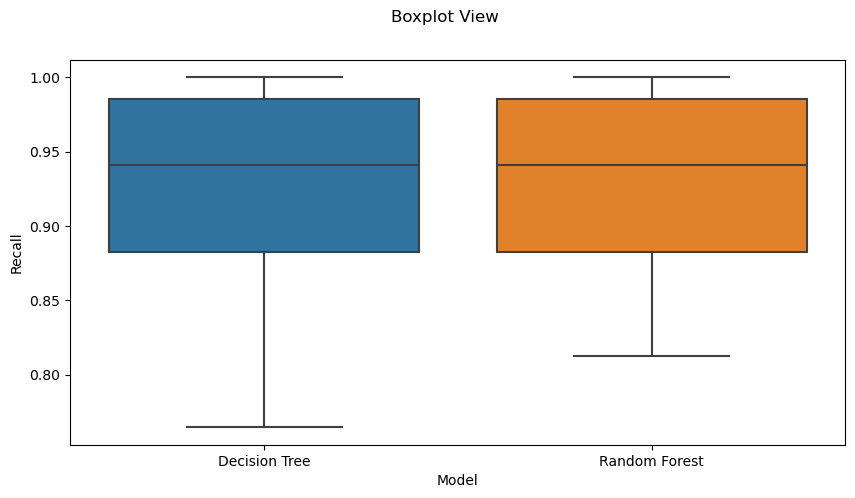

In [8]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('Decision Tree',pipe_dt))
models.append(('Random Forest',pipe_rdf))

#Model Evaluation
results =[]
names=[]
scoring ='recall_weighted'
print('Model Evaluation - Recall')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x_train,y_train,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

#Boxpot View
fig = plt.figure(figsize=(10,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Recall')
plt.xlabel('Model')
plt.show()

In [9]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params,cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train, y_train)
    model = gs_clf.best_estimator_
    
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
    print('\n')
    
    #Feature Importance - optimized
    print('Feature Importances')
    for name, score in zip(list(dataset),gs_clf.best_estimator_.named_steps['clf'].feature_importances_):
        print(name, round(score,2))
    
    #Output Validation Statistics
    target_names=['Kama','Rosa','Canadian']
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names))     

In [10]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)


Optimized Model

Model Name: RandomForestClassifier(random_state=100)


Feature Importances
A 0.22
P 0.21
C 0.04
LK 0.11
WK 0.12
A_Coef 0.08
LKG 0.23

Best Parameters: {'clf__bootstrap': False, 'clf__criterion': 'gini', 'clf__n_estimators': 200}

 [[13  1  0]
 [ 2 12  0]
 [ 0  0 14]]

               precision    recall  f1-score   support

        Kama       0.87      0.93      0.90        14
        Rosa       0.92      0.86      0.89        14
    Canadian       1.00      1.00      1.00        14

    accuracy                           0.93        42
   macro avg       0.93      0.93      0.93        42
weighted avg       0.93      0.93      0.93        42


Optimized Model

Model Name: DecisionTreeClassifier(random_state=100)


Feature Importances
A 0.34
P 0.02
C 0.0
LK 0.0
WK 0.03
A_Coef 0.06
LKG 0.55

Best Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 6}

 [[13  1  0]
 [ 2 12  0]
 [ 1  0 13]]

               precision    recall  f1-score   support

        Kama       0